In [1]:
#!pip install import-ipynb

In [2]:
import os

import import_ipynb
import torch
from utils import import_data,combine_data,split_data,standardize,compute_avg_delta_dataset,select_features #standardize
from mlp_utils import grid_search_mlp,grid_search_mlp_cv,grid_search_autoencoder,grid_search_mlp_multi
from plot_utils import plot_grid_search_results,plot_3d_actual_vs_predicted,compute_3d_metrics,plot_residuals_and_errors

In [3]:
# List of .mat files to load
mat_files = [os.path.join(os.getcwd(), 'dataset1.mat'),
             os.path.join(os.getcwd(), 'dataset2.mat'),
             os.path.join(os.getcwd(), 'dataset3.mat')]

# Dictionary to store the loaded data
datasets = import_data(mat_files)

print("\nAll loaded datasets:", list(datasets.keys()))

Loaded /home/jovyan/work/Sistemas Inteligentes/SI_Group_Project/dataset1.mat using scipy.io
Loaded /home/jovyan/work/Sistemas Inteligentes/SI_Group_Project/dataset2.mat using scipy.io
Loaded /home/jovyan/work/Sistemas Inteligentes/SI_Group_Project/dataset3.mat using scipy.io

All loaded datasets: ['dataset1', 'dataset2', 'dataset3']


In [4]:
import numpy as np

print("📊 Dataset metadata summary:\n")

for name, data in datasets.items():
    print(f"🧩 {name}:")
    # handle both scipy.io dicts and h5py-style dicts
    for var, val in data.items():
        if var.startswith("__"):
            continue
        try:
            if isinstance(val, np.ndarray):
                print(f"   • {var}: shape={val.shape}, dtype={val.dtype}")
            else:
                print(f"   • {var}: type={type(val).__name__}")
        except Exception as e:
            print(f"   • {var}: ⚠️ could not read metadata ({e})")
    print()

📊 Dataset metadata summary:

🧩 dataset1:
   • mag_sensors: shape=(2000, 12), dtype=uint16
   • tip_position: shape=(2000, 3), dtype=float64

🧩 dataset2:
   • mag_sensors2: shape=(2000, 12), dtype=uint16
   • tip_position2: shape=(2000, 3), dtype=float64

🧩 dataset3:
   • mag_sensors3: shape=(2000, 12), dtype=uint16
   • tip_position3: shape=(2000, 3), dtype=float64



In [5]:
# Combine
X, y = combine_data(datasets)

# Call function to compute the derived variables
X_dev = compute_avg_delta_dataset(X)  # also shape (N, 12)

# Concatenate original + derived features (columns)
X_aug = np.concatenate([X, X_dev], axis=1)

X_sel, idx, scores = select_features(X_aug,y)
print(idx)
print(scores)

# Split
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

# Standardize
X_train, X_val, X_test, y_train, y_val, y_test, x_scaler, y_scaler = standardize(
    X_train, X_val, X_test,
    y_train, y_val, y_test
)

# Split
X_train_dev, y_train_dev, X_val_dev, y_val_dev, X_test_dev, y_test_dev = split_data(X_dev, y)

# Standardize
X_train_dev, X_val_dev, X_test_dev, y_train_dev, y_val_dev, y_test_dev, x_scaler_dev, y_scaler_dev = standardize(
    X_train_dev, X_val_dev, X_test_dev,
    y_train_dev, y_val_dev, y_test_dev
)

# Split
X_train_aug, y_train_aug, X_val_aug, y_val_aug, X_test_aug, y_test_aug = split_data(X_aug, y)

# Standardize
X_train_aug, X_val_aug, X_test_aug, y_train_aug, y_val_aug, y_test_aug, x_scaler_aug, y_scaler_aug = standardize(
    X_train_aug, X_val_aug, X_test_aug,
    y_train_aug, y_val_aug, y_test_aug
)

# Split
X_train_sel, y_train_sel, X_val_sel, y_val_sel, X_test_sel, y_test_sel = split_data(X_sel, y)

# Standardize
X_train_sel, X_val_sel, X_test_sel, y_train_sel, y_val_sel, y_test_sel, x_scaler_sel, y_scaler_sel = standardize(
    X_train_sel, X_val_sel, X_test_sel,
    y_train_sel, y_val_sel, y_test_sel
)

print("X mean:", X_train.mean(axis=0)[:3])
print("y mean:", y_train.mean(axis=0))

experiment_results = {}

✅ dataset1: mag_sensors (2000, 12), tip_position (2000, 3)
✅ dataset2: mag_sensors2 (2000, 12), tip_position2 (2000, 3)
✅ dataset3: mag_sensors3 (2000, 12), tip_position3 (2000, 3)

📦 Combined shapes -> X: (6000, 12), y: (6000, 3)
[ 4 10 22 16  1 17 11  7 23 12  5 18  0  6  2 14 20 21  8  3  9 15 13 19]
[0.41619687 0.52416645 0.34699494 0.25339401 0.60532695 0.45728015
 0.40720517 0.48534027 0.27117185 0.25265862 0.60421929 0.5127665
 0.46965584 0.22157552 0.31743071 0.23656439 0.52966061 0.52281921
 0.44010736 0.08652047 0.28177557 0.28055834 0.56926974 0.47685792]
📊 Split -> Train: (4200, 12), Val: (900, 12), Test: (900, 12)
📊 Split -> Train: (4200, 12), Val: (900, 12), Test: (900, 12)
📊 Split -> Train: (4200, 24), Val: (900, 24), Test: (900, 24)
📊 Split -> Train: (4200, 24), Val: (900, 24), Test: (900, 24)
X mean: [5.94180789e-16 1.29050210e-15 1.11738661e-15]
y mean: [-2.50698933e-16  1.33477885e-16 -8.24097404e-15]


In [6]:
X_sel_x, idx_x, scores_x = select_features(X, y[:, 0], top_k=12)
print("X:", idx_x, scores_x)

X_sel_y, idx_y, scores_y = select_features(X, y[:, 1], top_k=12)
print("Y:", idx_y, scores_y)

X_sel_z, idx_z, scores_z = select_features(X, y[:, 2], top_k=12)
print("Z:", idx_z, scores_z)

X: [ 6  0  1  7  3  9  2  8  4 10 11  5] [0.6412722  0.62585505 0.42882413 0.44596403 0.31781641 0.23377304
 0.69265793 0.58896863 0.39144158 0.4425216  0.29882754 0.26928891]
Y: [11  5  4 10  2  8  1  0  9  7  3  6] [0.32720396 0.35869586 0.4405465  0.264312   0.58403885 0.62788954
 0.25925223 0.29416651 0.39016708 0.29616611 0.58306142 0.63310746]
Z: [ 8  2  9  1  6  4  7  0 10 11  3  5] [0.34364887 0.37167489 0.39217668 0.30297836 0.35878819 0.27483854
 0.36635941 0.35650287 0.42597503 0.37643224 0.33854485 0.31794133]


In [7]:
param_grid = {
    'hidden_layers': [
        [64, "RL", 32, "RL"],
        [128, "RL", 64, "RL", 32, "RL"],
        [256, "RL", 128, "RL", 64, "RL"],
        [256, "RL", 3, "TN", 256, "RL"],    # bottleneck
        [256, "RL", 6, "TN", 256, "RL"],    # bottleneck
        [64, "RL", 128, "RL", 64, "RL", 32, "RL"],  # expand-compress
        [128, "RL", 128, "RL", 128, "RL"],  # residual-like
    ],
    'lr': [1e-3, 5e-4, 1e-4],
    'batch_size': [16, 32],
    'epochs': [100],
    'k_folds': [10]
}

fast_grid = {
    "hidden_layers": [[256, "RL", 128, "RL", 64, "RL"]],
    "lr": [0.001],
    "batch_size": [16],
    "epochs": [100],
    "k_folds": [10]
}

best_params, best_loss, results, best_model, x_scaler, y_scaler = grid_search_mlp_cv(
    X, y,
    input_dim=X.shape[1],
    output_dim=y.shape[1],
    param_grid=fast_grid,
)

print("✅ Best params:", best_params)
print("📉 Best mean loss:", best_loss)

# Convert results to pandas DataFrame for easy viewing
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

#experiment_results["basic_mlp"] = {
#    "results": results,
#    "best_model": best_model,
#    "best_params": best_params,
#    "best_loss": results[0][1]
#}
#
#print("✅ Best params:", best_params)
#print("✅ Validation loss:", results[0][1])


🔍 Testing params: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.001, 'batch_size': 16, 'epochs': 100} | k_folds=10
Fold 1/10: Val Loss = 0.003055
Fold 2/10: Val Loss = 0.002575
Fold 3/10: Val Loss = 0.002158
Fold 4/10: Val Loss = 0.002428
Fold 5/10: Val Loss = 0.002215
Fold 6/10: Val Loss = 0.002125
Fold 7/10: Val Loss = 0.002153
Fold 8/10: Val Loss = 0.001908
Fold 9/10: Val Loss = 0.002038
Fold 10/10: Val Loss = 0.002594

📊 Mean CV Loss: 0.002325 ± 0.000323

🏆 Best parameters found: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.001, 'batch_size': 16, 'epochs': 100, 'k_folds': 10}
   Mean CV Loss: 0.002325
✅ Best params: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.001, 'batch_size': 16, 'epochs': 100, 'k_folds': 10}
📉 Best mean loss: 0.0023250389378517864
                                              params  mean_loss  std_loss
0  {'hidden_layers': [256, 'RL', 128, 'RL', 64, '...   0.002325  0.000323


In [8]:
# --- Example param grid ---
param_grid = {
    'hidden_layers': [
        [64, "RL", 32, "RL"],
        [128, "RL", 64, "RL", 32, "RL"],
        [256, "RL", 128, "RL", 64, "RL"],
        [256, "RL", 3, "TN", 256, "RL"],    # bottleneck
        [256, "RL", 6, "TN", 256, "RL"],    # bottleneck
        [64, "RL", 128, "RL", 64, "RL", 32, "RL"],  # expand-compress
        [128, "RL", 128, "RL", 128, "RL"],  # residual-like
    ],
    'lr': [1e-3, 5e-4, 1e-4],
    'batch_size': [16, 32],
    'epochs': [100]
}

fast_grid = {
    'hidden_layers': [[256, 'RL', 6, 'TN', 256, 'RL']],
    'lr': [0.0005],
    'batch_size': [32],
    'epochs': [100]
}

cv_grid = {
    k: [v] if (k == "hidden_layers" and isinstance(v[0], (int, str)))
       else (v if isinstance(v, (list, tuple, np.ndarray)) else [v])
    for k, v in best_params.items() if k != "k_folds"
}

results, best_model, best_params = grid_search_mlp(
    X_train, y_train, X_val, y_val,
    input_dim=12, output_dim=3, param_grid=cv_grid
)

experiment_results["basic_mlp"] = {
    "results": results,
    "best_model": best_model,
    "best_params": best_params,
    "best_loss": results[0][1]
}

print("✅ Best params:", best_params)
print("✅ Validation loss:", results[0][1])

Testing: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.001, 'batch_size': 16, 'epochs': 100}
✅ Best params: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.001, 'batch_size': 16, 'epochs': 100}
✅ Validation loss: 0.0024459711275994778


In [9]:
    # Set model to evaluation mode
    best_model.eval()

    # Predict
    with torch.no_grad():
        X_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_pred = best_model(X_tensor).cpu().numpy()

    # De-standardize
    y_pred_real = y_scaler.inverse_transform(y_pred)
    y_test_real = y_scaler.inverse_transform(y_test)

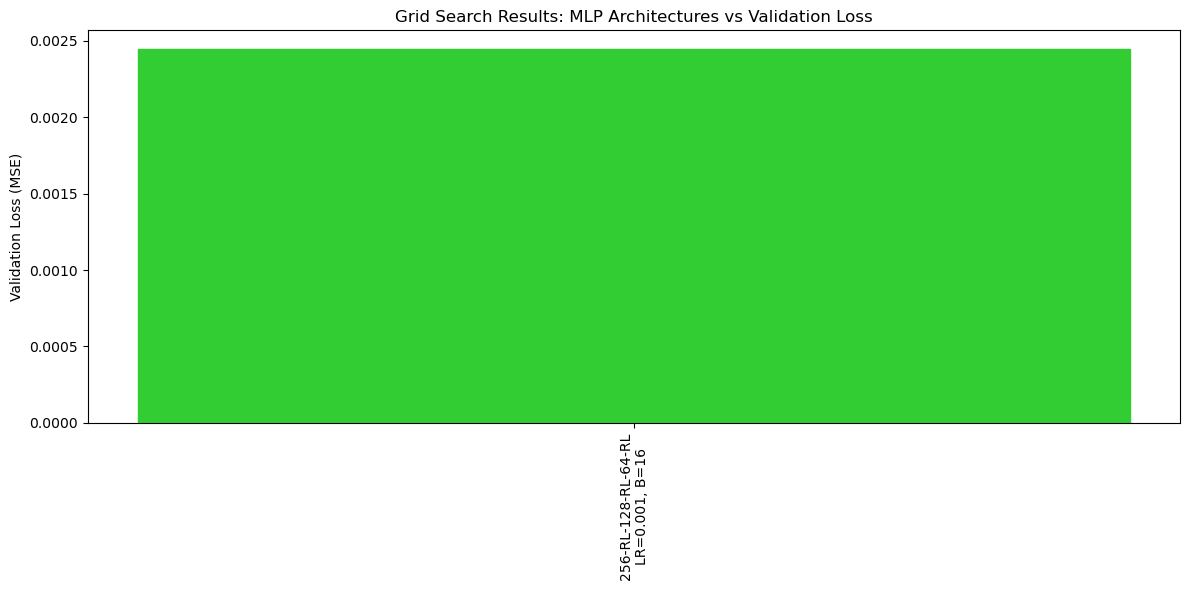

✅ Best model: 256-RL-128-RL-64-RL
LR=0.001, B=16 with val_loss = 0.002446


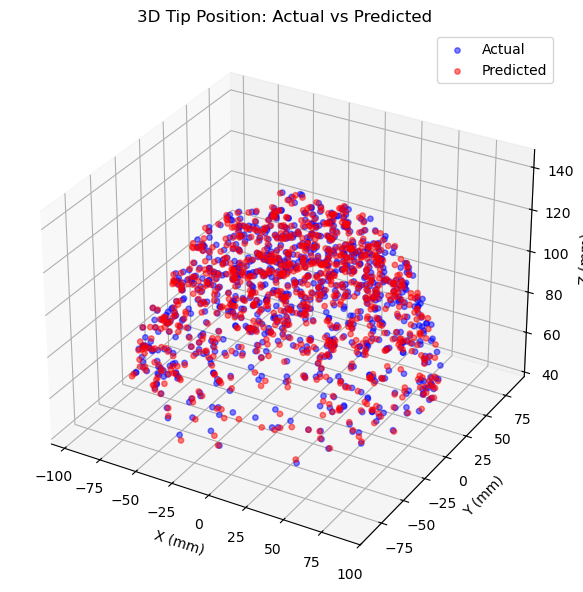

Mean residual distance: 2.113 mm
RMSE [x, y, z]: [1.52706518 1.447325   1.24018453]
MAE  [x, y, z]: [1.2302298  1.07820895 0.87178611]
Mean 3D deviation: 2.1130 ± 1.2247


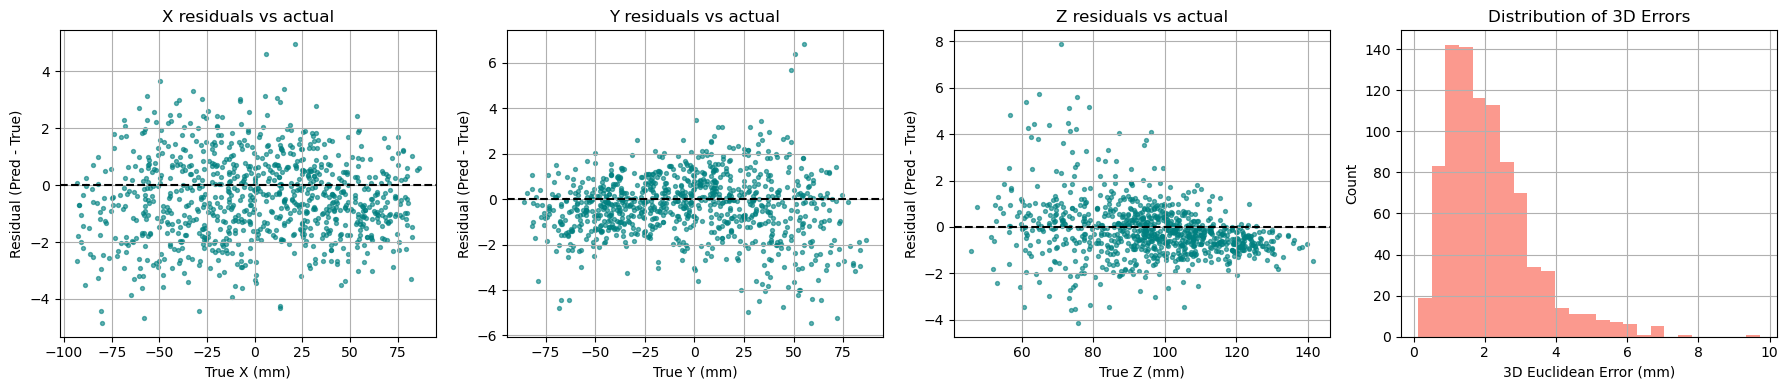

Mean 3D deviation: 2.1130 ± 1.2247


In [10]:
_,_ = plot_grid_search_results(results, model_type="MLP")

_, _, _ = plot_3d_actual_vs_predicted(y_test_real, y_pred_real)

_ = compute_3d_metrics(y_pred_real, y_test_real)

_,_ = plot_residuals_and_errors(y_test_real, y_pred_real)

In [10]:
param_grid = {
    'ae_layers': [
        [64, "RL", 8, "TN", 64, "RL"],
        [128, "RL", 16, "TN", 128, "RL"],
    ],
    'reg_layers': [
        [32, "RL"],
        [64, "RL", 32, "RL"]
    ],
    'lr': [1e-3, 5e-4],
    'batch_size': [16, 32],
    'ae_epochs': [50],
    'reg_epochs': [100],
    'fine_tune': [False, True],
}

fast_grid = {
    'ae_layers': [[128, "RL", 16, "TN", 128, "RL"]],
    'reg_layers': [[64, "RL", 32, "RL"]],
    'lr': [5e-4],
    'batch_size': [16],
    'ae_epochs': [50],
    'reg_epochs': [100],
    'fine_tune': [True],
}

results, best_model, best_params = grid_search_autoencoder(
    X_train, y_train, X_val, y_val,
    input_dim=12, output_dim=3,
    param_grid=fast_grid
)


🔍 Testing config:
{'ae_layers': [128, 'RL', 16, 'TN', 128, 'RL'], 'reg_layers': [64, 'RL', 32, 'RL'], 'lr': 0.0005, 'batch_size': 16, 'ae_epochs': 50, 'reg_epochs': 100, 'fine_tune': True}
→ AE Val Loss: 0.000436 | REG Val Loss: 0.002457

✅ Best config: {'ae_layers': [128, 'RL', 16, 'TN', 128, 'RL'], 'reg_layers': [64, 'RL', 32, 'RL'], 'lr': 0.0005, 'batch_size': 16, 'ae_epochs': 50, 'reg_epochs': 100, 'fine_tune': True}
✅ Best Val Loss: 0.002457


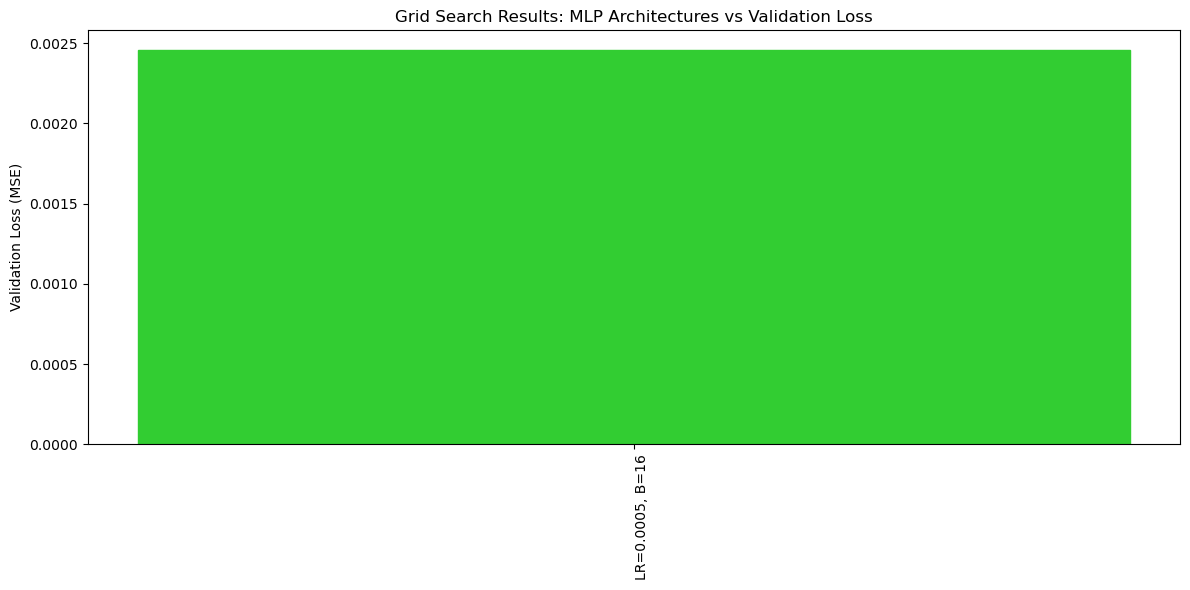

✅ Best model: 
LR=0.0005, B=16 with val_loss = 0.002457


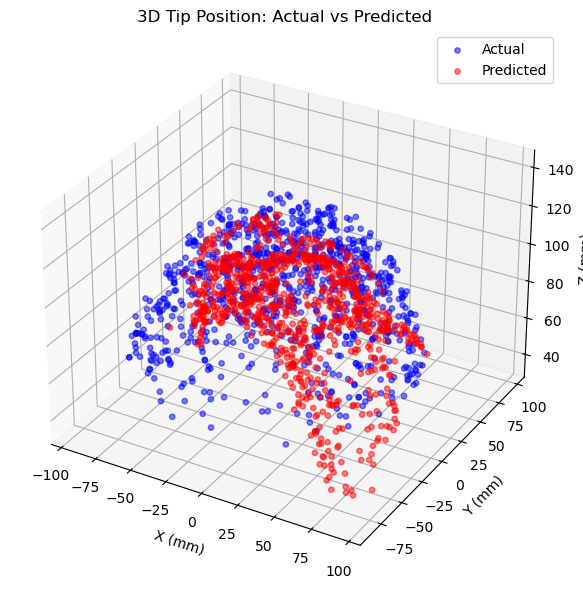

Mean residual distance: 42.007 mm
RMSE [x, y, z]: [27.93726114 34.93461029 19.08467134]
MAE  [x, y, z]: [19.85707314 28.49245193 13.98261123]
Mean 3D deviation: 42.0072 ± 24.5059


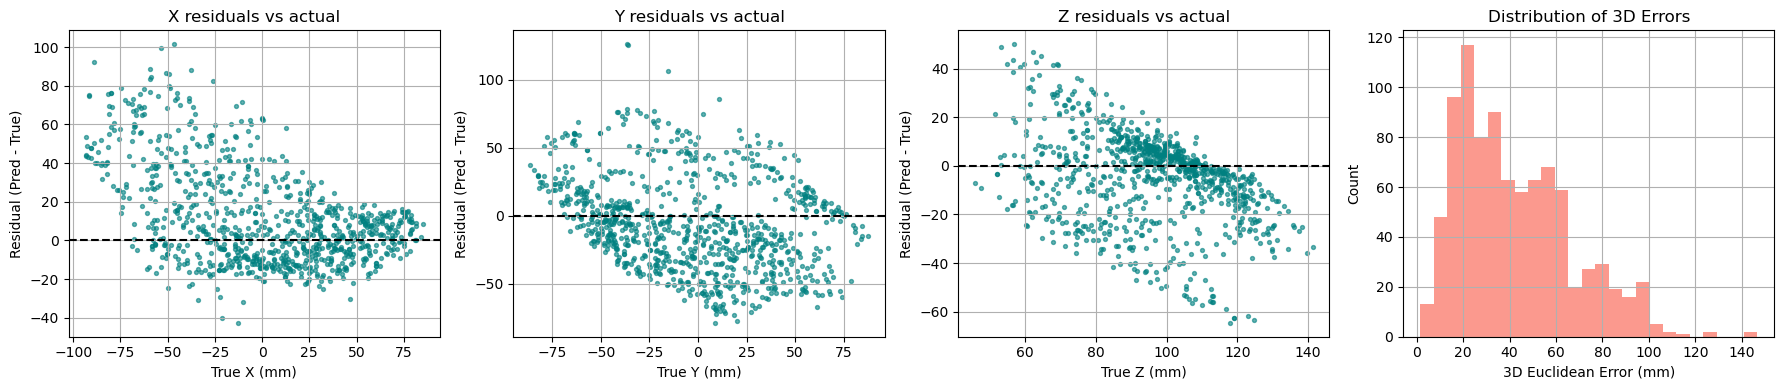

Mean 3D deviation: 42.0072 ± 24.5059


In [11]:
# Set model to evaluation mode
best_model.eval()

# Predict
with torch.no_grad():
    X_tensor = torch.tensor(X_test_dev, dtype=torch.float32)
    y_pred = best_model(X_tensor).cpu().numpy()

# De-standardize
y_pred_real = y_scaler_dev.inverse_transform(y_pred)
y_test_real = y_scaler_dev.inverse_transform(y_test_dev)


_,_ = plot_grid_search_results(results, model_type="MLP")

_, _, _ = plot_3d_actual_vs_predicted(y_test_real, y_pred_real)

_ = compute_3d_metrics(y_pred_real, y_test_real)

_,_ = plot_residuals_and_errors(y_test_real, y_pred_real)

In [13]:
# --- Example param grid ---
param_grid = {
    'hidden_layers': [
        [64, "RL", 32, "RL"],
        [128, "RL", 64, "RL", 32, "RL"],
        [256, "RL", 128, "RL", 64, "RL"],
        [256, "RL", 3, "TN", 256, "RL"],    # bottleneck
        [256, "RL", 6, "TN", 256, "RL"],    # bottleneck
        [64, "RL", 128, "RL", 64, "RL", 32, "RL"],  # expand-compress
        [128, "RL", 128, "RL", 128, "RL"],  # residual-like
    ],
    'lr': [1e-3, 5e-4, 1e-4],
    'batch_size': [16, 32],
    'epochs': [100]
}
fast_grid = {
    'hidden_layers': [[256, 'RL', 128, 'RL', 64, 'RL']],
    'lr': [0.0005],
    'batch_size': [32],
    'epochs': [100, 200, 500, 1000]
}

results, best_model, best_params = grid_search_mlp(
    X_train_dev, y_train_dev, X_val_dev, y_val_dev,
    input_dim=12, output_dim=3, param_grid=fast_grid
)

print("✅ Best params:", best_params)
print("✅ Validation loss:", results[0][1])

Testing: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}
Testing: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 200}
Testing: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 500}
Testing: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 1000}
✅ Best params: {'hidden_layers': [256, 'RL', 128, 'RL', 64, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 1000}
✅ Validation loss: 0.002048185793682933


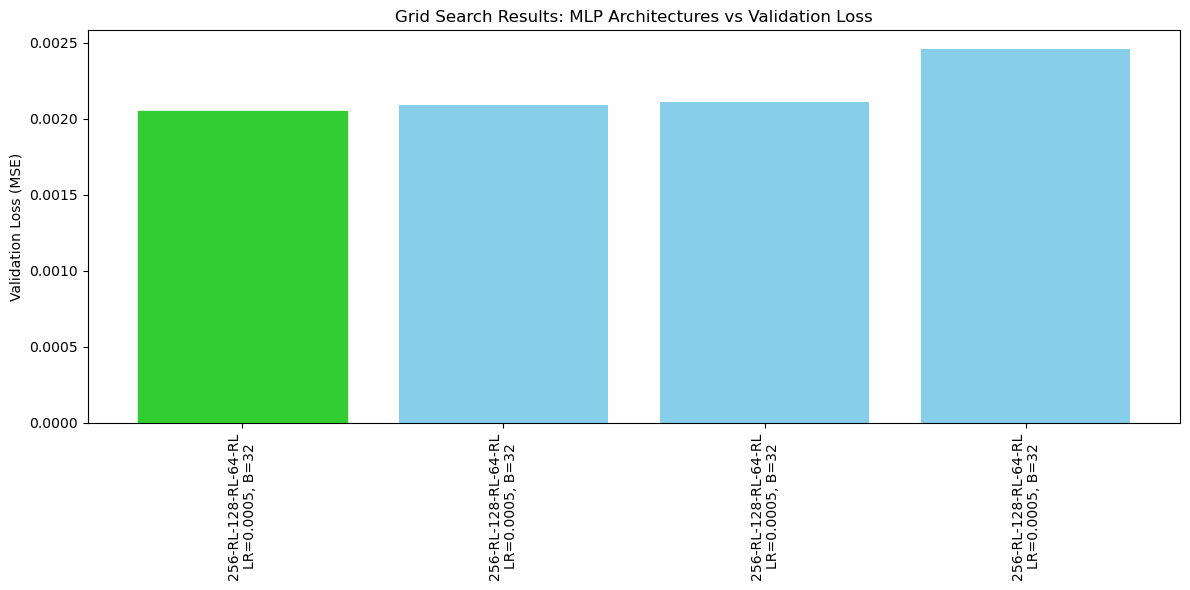

✅ Best model: 256-RL-128-RL-64-RL
LR=0.0005, B=32 with val_loss = 0.002048


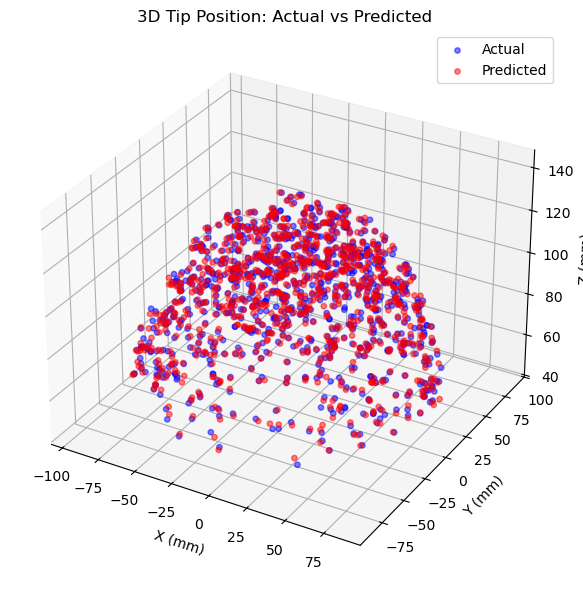

Mean residual distance: 1.853 mm
RMSE [x, y, z]: [1.39998669 1.2634836  1.09314282]
MAE  [x, y, z]: [1.09153524 0.94074505 0.73313763]
Mean 3D deviation: 1.8534 ± 1.1473


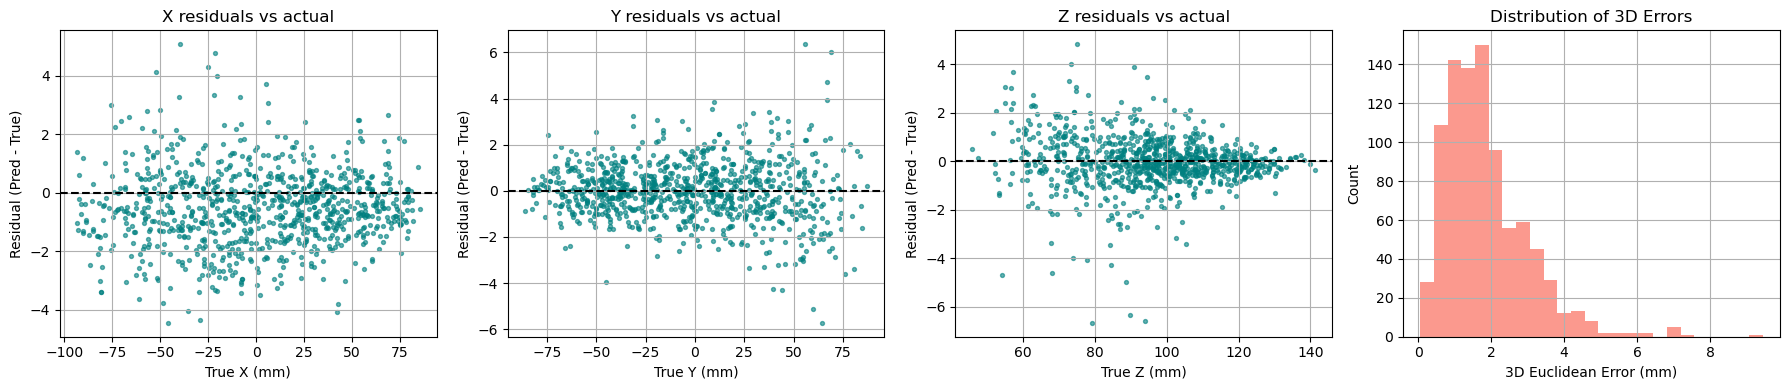

Mean 3D deviation: 1.8534 ± 1.1473


In [16]:
# Set model to evaluation mode
best_model.eval()

# Predict
with torch.no_grad():
    X_tensor = torch.tensor(X_test_dev, dtype=torch.float32)
    y_pred = best_model(X_tensor).cpu().numpy()

# De-standardize
y_pred_real = y_scaler_dev.inverse_transform(y_pred)
y_test_real = y_scaler_dev.inverse_transform(y_test_dev)

_,_ = plot_grid_search_results(results, model_type="MLP")

_, _, _ = plot_3d_actual_vs_predicted(y_test_real, y_pred_real)

_ = compute_3d_metrics(y_pred_real, y_test_real)

_,_ = plot_residuals_and_errors(y_test_real, y_pred_real)

In [24]:
param_grid = {
    "pair_arch":  [[512,"RL",256,"RL",128,"RL"]],
    "mid_arch":   [[128,"RL",64,"RL"]],
    "final_arch": [[64,"RL",32,"RL"]],
    "lr": [1e-3],
    "batch_size": [16],
    "epochs": [100]
}

results, best_model, best_params = grid_search_mlp_multi(
    X_train, y_train, X_val, y_val, param_grid
)

print("✅ Best params:", best_params)
print("✅ Validation loss:", results[0][1])

Testing: {'pair_arch': [512, 'RL', 256, 'RL', 128, 'RL'], 'mid_arch': [128, 'RL', 64, 'RL'], 'final_arch': [64, 'RL', 32, 'RL'], 'lr': 0.001, 'batch_size': 16, 'epochs': 100}
✅ Best params: {'pair_arch': [512, 'RL', 256, 'RL', 128, 'RL'], 'mid_arch': [128, 'RL', 64, 'RL'], 'final_arch': [64, 'RL', 32, 'RL'], 'lr': 0.001, 'batch_size': 16, 'epochs': 100}
✅ Validation loss: 0.0039060846902430058


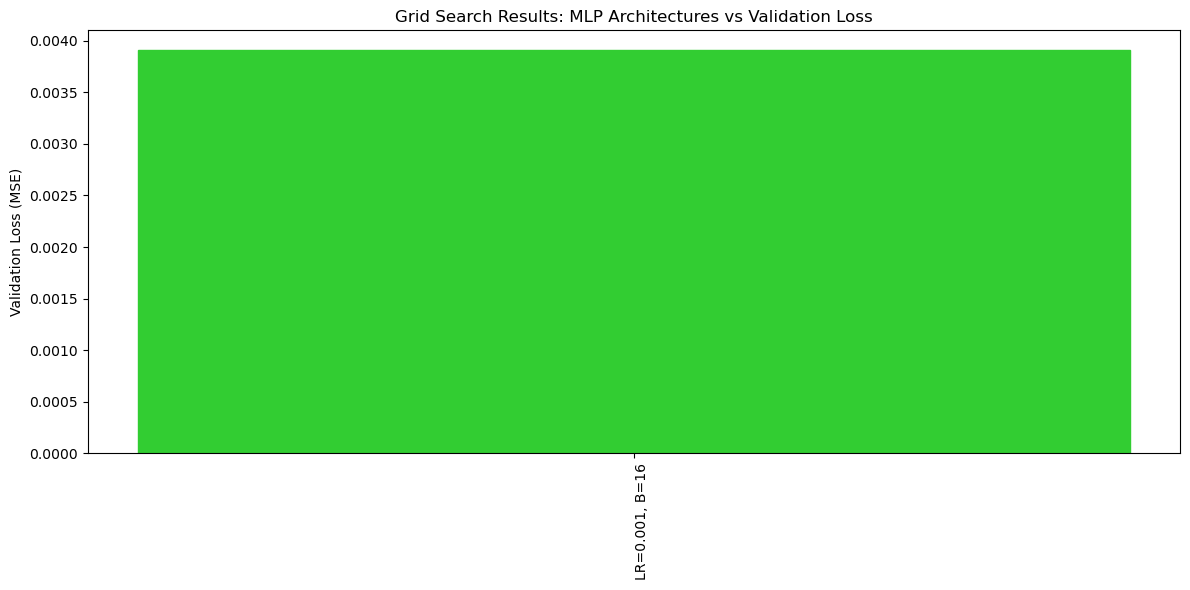

✅ Best model: 
LR=0.001, B=16 with val_loss = 0.003906


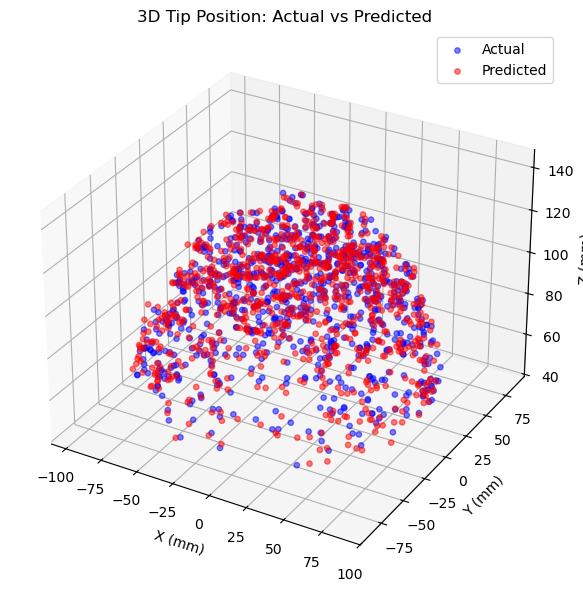

Mean residual distance: 3.158 mm
RMSE [x, y, z]: [2.22241358 2.29521838 1.51812082]
MAE  [x, y, z]: [1.72430506 1.84131974 1.10712135]
Mean 3D deviation: 3.1584 ± 1.5926


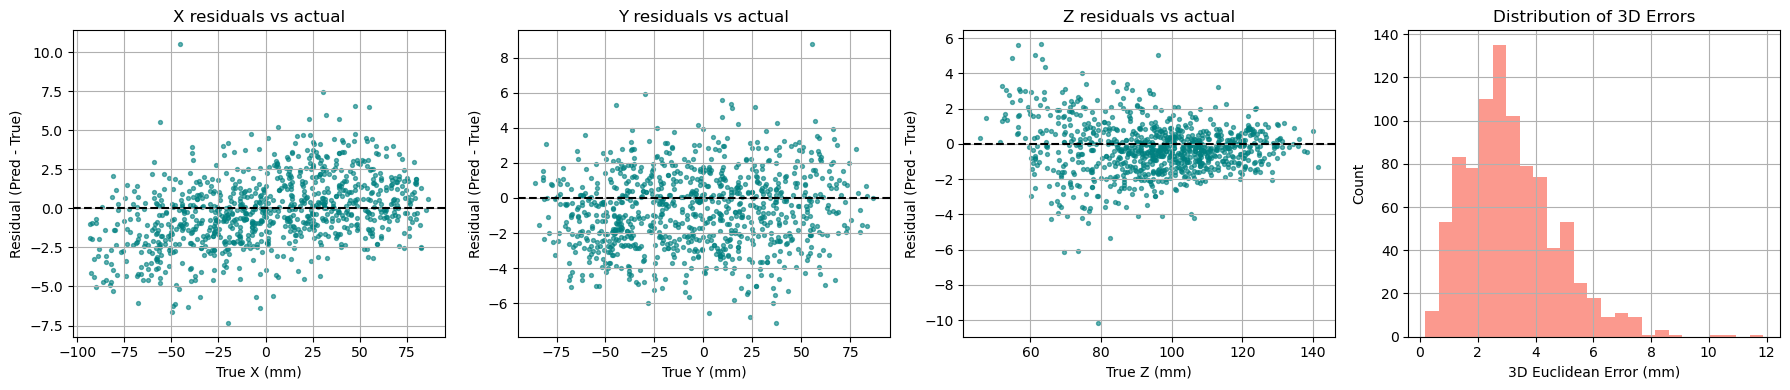

Mean 3D deviation: 3.1584 ± 1.5926


In [25]:
# Set model to evaluation mode
best_model.eval()

# Predict
with torch.no_grad():
    X_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred = best_model(X_tensor).cpu().numpy()

# De-standardize
y_pred_real = y_scaler.inverse_transform(y_pred)
y_test_real = y_scaler.inverse_transform(y_test)

_,_ = plot_grid_search_results(results, model_type="MLP")

_, _, _ = plot_3d_actual_vs_predicted(y_test_real, y_pred_real)

_ = compute_3d_metrics(y_pred_real, y_test_real)

_,_ = plot_residuals_and_errors(y_test_real, y_pred_real)

In [27]:
# --- Example param grid ---
param_grid = {
    'hidden_layers': [
        [64, "RL", 32, "RL"],
        [128, "RL", 64, "RL", 32, "RL"],
        [256, "RL", 128, "RL", 64, "RL"],
        [256, "RL", 6, "TN", 256, "RL"],    # bottleneck
        [64, "RL", 128, "RL", 64, "RL", 32, "RL"],  # expand-compress
        [128, "RL", 128, "RL", 128, "RL"],  # residual-like
    ],
    'lr': [5e-4],
    'batch_size': [16, 32],
    'epochs': [100]
}

fast_grid = {
    'hidden_layers': [[512, "RL", 256, "RL", 128, "RL", 64, "RL", 32, "RL"],
                      [512, "RL", 256, "RL", 128, "RL", 64, "RL", 32, "RL", 16, "RL"],
                      [512, "RL", 256, "RL", 128, "RL", 64, "RL", 32, "RL", 16, "RL", 8, "RL"]],
    'lr': [0.0005],
    'batch_size': [32],
    'epochs': [100]
}

# --- Feature index mapping per coordinate ---
feature_idx = {'x': idx_x, 'y': idx_y, 'z': idx_z}

experts = {}
for i, coord in enumerate(['x', 'y', 'z']):
    print(f"\n🔹 Training expert for {coord.upper()} coordinate")

    idx = feature_idx[coord]  # use top features for this coordinate
    print(f"🧩 Using {len(idx)} selected features: {idx}")

    results, best_model, best_params = grid_search_mlp(
        X_train[:, idx], y_train[:, [i]],   # select features for training
        X_val[:, idx],   y_val[:, [i]],     # and validation
        input_dim=len(idx), output_dim=1,
        param_grid=fast_grid
    )

    experts[coord] = {
        "results": results,
        "best_model": best_model,
        "best_params": best_params,
        "best_loss": results[0][1],
        "feature_idx": idx
    }

# ✅ Summary
for coord, data in experts.items():
    print(f"\n{coord.upper()} → Best loss: {data['best_loss']:.6f} (features used: {data['feature_idx']})")



🔹 Training expert for X coordinate
🧩 Using 12 selected features: [ 6  0  1  7  3  9  2  8  4 10 11  5]
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL', 16, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL', 16, 'RL', 8, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}

🔹 Training expert for Y coordinate
🧩 Using 12 selected features: [11  5  4 10  2  8  1  0  9  7  3  6]
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL', 16, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL', 16, 'RL', 8, 'RL'], 'lr': 0

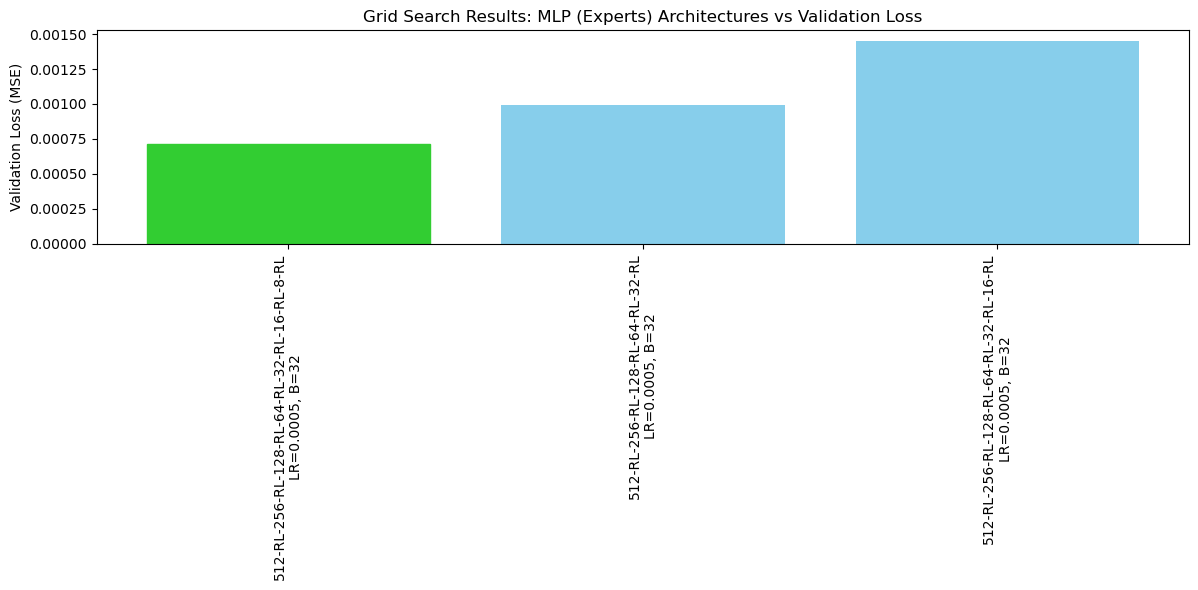

✅ Best model: 512-RL-256-RL-128-RL-64-RL-32-RL-16-RL-8-RL
LR=0.0005, B=32 with val_loss = 0.000714


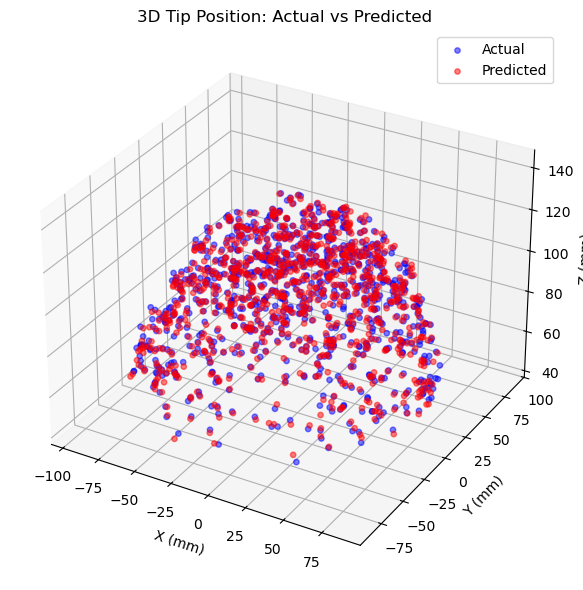

Mean residual distance: 1.800 mm
RMSE [x, y, z]: [1.20616419 1.25820558 1.0561839 ]
MAE  [x, y, z]: [0.96784553 0.93886585 0.76847953]
Mean 3D deviation: 1.7997 ± 0.9563


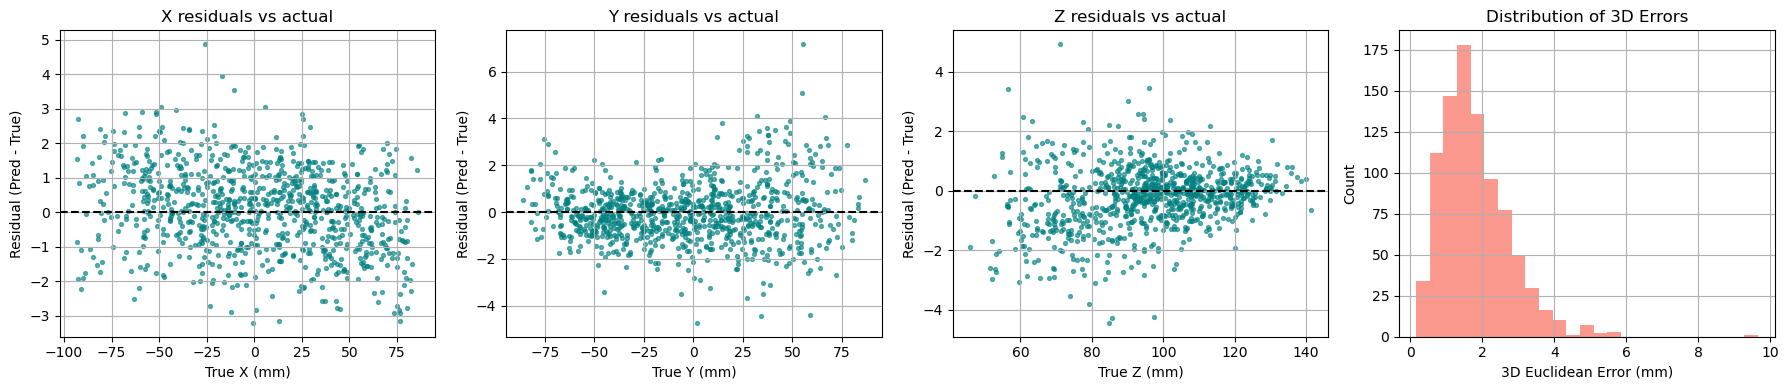

Mean 3D deviation: 1.7997 ± 0.9563


In [28]:
# --- Predict with all 3 experts ---
with torch.no_grad():
    preds = []
    for coord in ['x', 'y', 'z']:
        model = experts[coord]["best_model"]
        idx   = experts[coord]["feature_idx"]   # 🔹 selected feature indices
        model.eval()

        X_tensor = torch.tensor(X_test[:, idx], dtype=torch.float32)  # use same subset
        pred = model(X_tensor).cpu().numpy()  # shape (N, 1)
        preds.append(pred)

    y_pred = np.hstack(preds)  # shape (N, 3)

# --- De-standardize ---
y_pred_real = y_scaler.inverse_transform(y_pred)
y_test_real = y_scaler.inverse_transform(y_test)

# --- Evaluation & Visualization ---
_, _ = plot_grid_search_results(experts['x']["results"], model_type="MLP (Experts)")
_, _, _ = plot_3d_actual_vs_predicted(y_test_real, y_pred_real)
_ = compute_3d_metrics(y_pred_real, y_test_real)
_, _ = plot_residuals_and_errors(y_test_real, y_pred_real)


In [29]:
#!pip install tensorflow-cpu

Epoch 1/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - loss: 0.3821 - val_loss: 0.1487
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.0983 - val_loss: 0.0761
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.0554 - val_loss: 0.0467
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.0369 - val_loss: 0.0358
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.0298 - val_loss: 0.0300
Epoch 6/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0263 - val_loss: 0.0294
Epoch 7/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.0240 - val_loss: 0.0265
Epoch 8/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.0215 - val_loss: 0.0224
Epoch 9/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.0191 - val_loss: 0.0222
Epoch 10/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.0174 - val_loss: 0.0192
Epoch 11/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.0160 - val_loss: 0.0175
Epoch 12/100
263/26

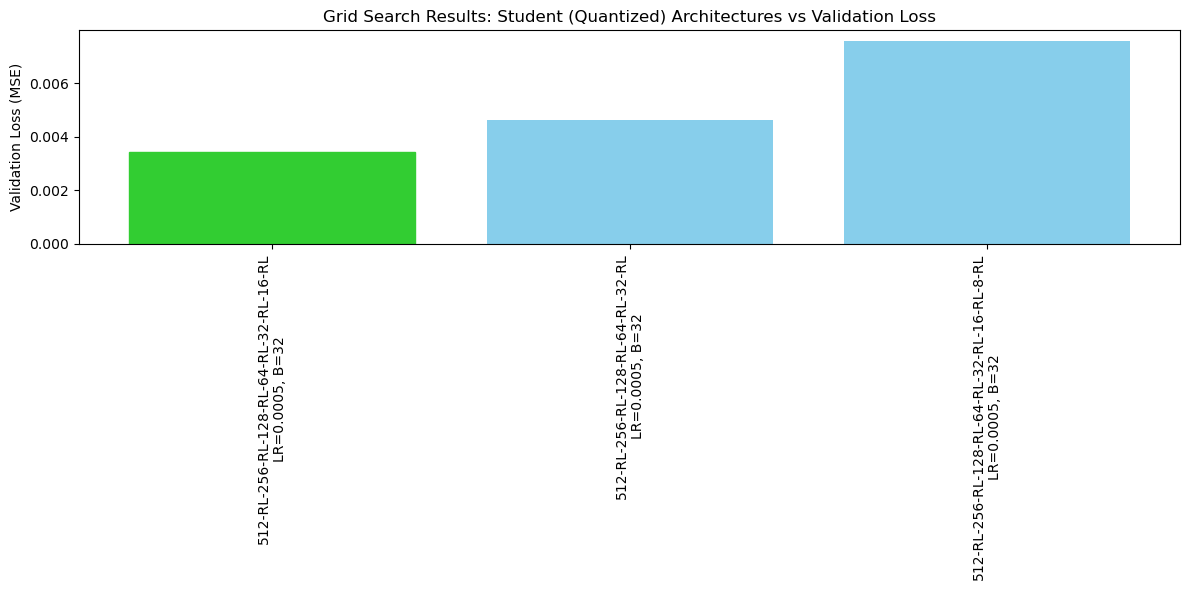

✅ Best model: 512-RL-256-RL-128-RL-64-RL-32-RL-16-RL
LR=0.0005, B=32 with val_loss = 0.003443


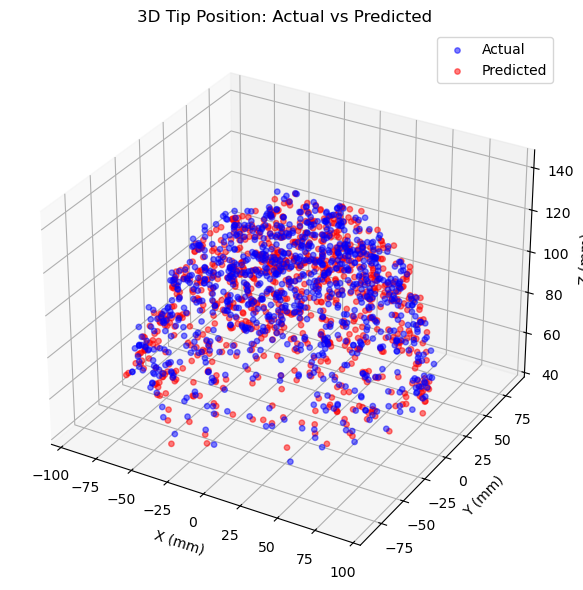

Mean residual distance: 3.476 mm
RMSE [x, y, z]: [2.50601366 2.37835103 1.73076239]
MAE  [x, y, z]: [1.97044401 1.86238203 1.32841882]
Mean 3D deviation: 3.4764 ± 1.6872


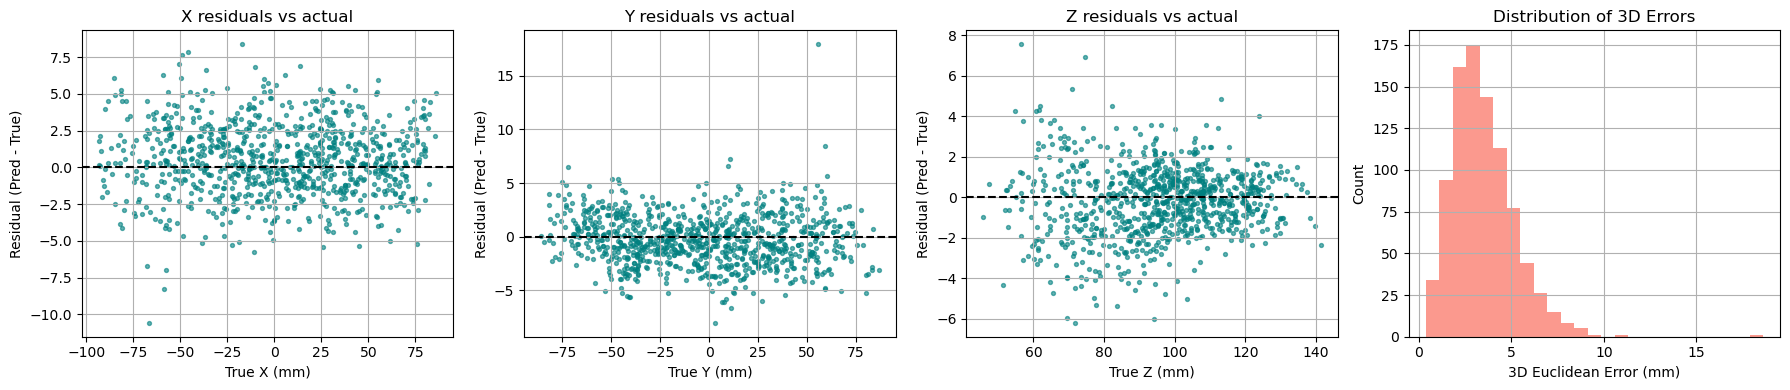

Mean 3D deviation: 3.4764 ± 1.6872
INFO:tensorflow:Assets written to: /tmp/tmpjihik8sd/assets


INFO:tensorflow:Assets written to: /tmp/tmpjihik8sd/assets


Saved artifact at '/tmp/tmpjihik8sd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140161900538832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140161900539024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140161899050000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140161899051344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140161899049808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140161899047312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140161902593424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140161902598992: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1761027822.353270 3167209 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1761027822.353285 3167209 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-10-21 07:23:42.353476: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjihik8sd
2025-10-21 07:23:42.353714: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-21 07:23:42.353718: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpjihik8sd
I0000 00:00:1761027822.355643 3167209 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-10-21 07:23:42.356003: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-21 07:23:42.370960: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpjihik8sd
2025-10-21 07:23:42.374772: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [30]:
# --- Predict with all 3 experts ---
with torch.no_grad():
    preds = []
    for coord in ['x', 'y', 'z']:
        model = experts[coord]["best_model"]
        idx   = experts[coord]["feature_idx"]   # 🔹 selected feature indices
        model.eval()

        X_tensor = torch.tensor(X_train[:, idx], dtype=torch.float32)  # use same subset
        pred = model(X_tensor).cpu().numpy()  # shape (N, 1)
        preds.append(pred)

    y_pred = np.hstack(preds)  # shape (N, 3)


import tensorflow as tf
from tensorflow.keras import layers, models

# Define a small student model
student = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(24, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(6, activation='relu'),
    layers.Dense(3)  # same output shape as teacher
])

student.compile(optimizer='adam', loss='mse')
student.fit(X_train, y_pred, epochs=100, batch_size=16, validation_data=(X_val, y_val))

# --- Evaluate the float (unquantized) student model ---
y_pred_student = student.predict(X_test)

# De-standardize (if used)
y_pred_real = y_scaler.inverse_transform(y_pred_student)
y_test_real = y_scaler.inverse_transform(y_test)
# --- Evaluate performance ---
_, _ = plot_grid_search_results(results, model_type="Student (Quantized)")
_, _, _ = plot_3d_actual_vs_predicted(y_test_real, y_pred_real)
_ = compute_3d_metrics(y_pred_real, y_test_real)
_, _ = plot_residuals_and_errors(y_test_real, y_pred_real)

converter = tf.lite.TFLiteConverter.from_keras_model(student)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("student_model_quant.tflite", "wb") as f:
    f.write(tflite_model)

/opt/conda/lib/python3.13/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


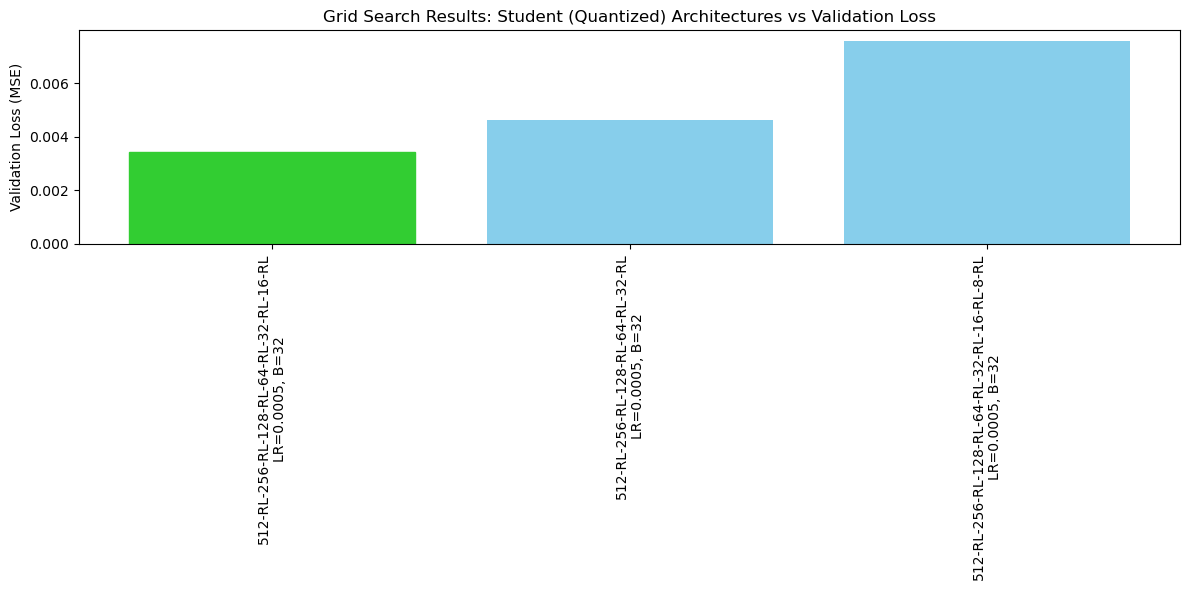

✅ Best model: 512-RL-256-RL-128-RL-64-RL-32-RL-16-RL
LR=0.0005, B=32 with val_loss = 0.003443


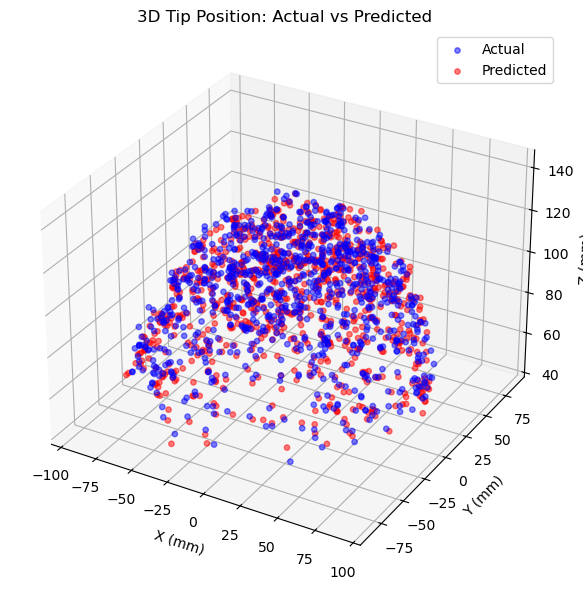

Mean residual distance: 3.476 mm
RMSE [x, y, z]: [2.50601437 2.37835127 1.73076231]
MAE  [x, y, z]: [1.9704444  1.86238242 1.32841881]
Mean 3D deviation: 3.4764 ± 1.6872


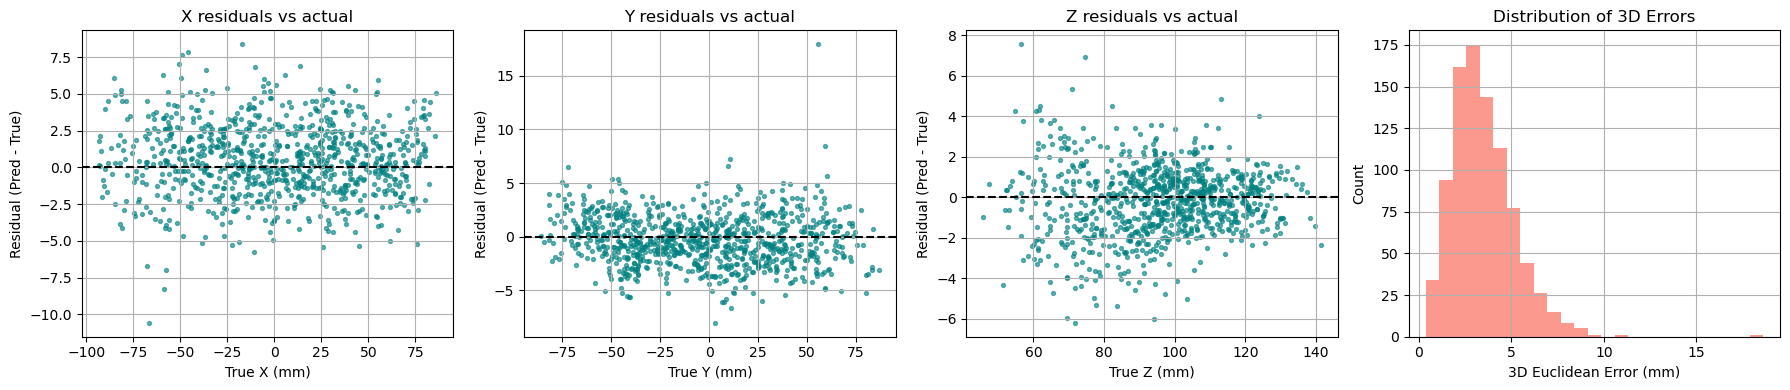

Mean 3D deviation: 3.4764 ± 1.6872


In [31]:
import numpy as np
import tensorflow as tf

# --- Load quantized TFLite model ---
interpreter = tf.lite.Interpreter(model_path="student_model_quant.tflite")
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# --- Prepare input data (e.g., X_test) ---
X_eval = X_test.astype(np.float32)  # or X_train if you prefer to compare same data
y_true = y_test

# --- Predict with the quantized model ---
y_pred_quant = []
for i in range(len(X_eval)):
    # Reshape one sample to match the model’s input shape (1, n_features)
    input_data = X_eval[i:i+1]
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred_quant.append(output_data[0])

y_pred_quant = np.array(y_pred_quant)  # shape (N, 3)

# --- De-standardize (if your data was scaled) ---
y_pred_real = y_scaler.inverse_transform(y_pred_quant)
y_true_real = y_scaler.inverse_transform(y_true)

# --- Evaluate performance ---
_, _ = plot_grid_search_results(results, model_type="Student (Quantized)")
_, _, _ = plot_3d_actual_vs_predicted(y_true_real, y_pred_real)
_ = compute_3d_metrics(y_pred_real, y_true_real)
_, _ = plot_residuals_and_errors(y_true_real, y_pred_real)

In [9]:
# --- Example param grid ---
param_grid = {
    'hidden_layers': [
        [64, "RL", 32, "RL"],
        [128, "RL", 64, "RL", 32, "RL"],
        [256, "RL", 128, "RL", 64, "RL"],
        [256, "RL", 6, "TN", 256, "RL"],    # bottleneck
        [64, "RL", 128, "RL", 64, "RL", 32, "RL"],  # expand-compress
        [128, "RL", 128, "RL", 128, "RL"],  # residual-like
    ],
    'lr': [5e-4],
    'batch_size': [16, 32],
    'epochs': [100]
}

fast_grid = {
    'hidden_layers': [[512, "RL", 256, "RL", 128, "RL", 64, "RL", 32, "RL", 16, "RL"]],
    'lr': [0.0005],
    'batch_size': [32],
    'epochs': [100]
}

# --- Feature index mapping per coordinate ---
feature_idx = {'x': idx_x, 'y': idx_y, 'z': idx_z}


experts = {}

for i, coord in enumerate(['x', 'y', 'z']):
    print(f"\n🔹 Training expert for {coord.upper()} coordinate")

    idx = feature_idx[coord]  # use top features for this coordinate
    print(f"🧩 Using {len(idx)} selected features: {idx}")

    # --- Prepare training data ---
    X_train_sub = X_train[:, idx]
    X_val_sub   = X_val[:, idx]

    # For Z expert, append outputs (predictions) of X and Y experts
    if coord == 'z':
        print("⚙️  Adding predictions from X and Y experts as extra inputs")

        # Get predictions from previously trained experts
        y_pred_x_train = experts['x']["best_model"](torch.tensor(X_train[:, feature_idx['x']], dtype=torch.float32)).detach().numpy()
        y_pred_y_train = experts['y']["best_model"](torch.tensor(X_train[:, feature_idx['y']], dtype=torch.float32)).detach().numpy()

        y_pred_x_val = experts['x']["best_model"](torch.tensor(X_val[:, feature_idx['x']], dtype=torch.float32)).detach().numpy()
        y_pred_y_val = experts['y']["best_model"](torch.tensor(X_val[:, feature_idx['y']], dtype=torch.float32)).detach().numpy()

        # Concatenate predictions as additional inputs
        X_train_sub = np.hstack([X_train_sub, y_pred_x_train, y_pred_y_train])
        X_val_sub   = np.hstack([X_val_sub,   y_pred_x_val,   y_pred_y_val])

        print(f"🧠 New input shape for Z expert: {X_train_sub.shape[1]} features")

    # --- Train expert model ---
    results, best_model, best_params = grid_search_mlp(
        X_train_sub, y_train[:, [i]],
        X_val_sub,   y_val[:, [i]],
        input_dim=X_train_sub.shape[1], output_dim=1,
        param_grid=fast_grid
    )

    experts[coord] = {
        "results": results,
        "best_model": best_model,
        "best_params": best_params,
        "best_loss": results[0][1],
        "feature_idx": idx
    }

# ✅ Summary
for coord, data in experts.items():
    print(f"\n{coord.upper()} → Best loss: {data['best_loss']:.6f} (features used: {data['feature_idx']})")


🔹 Training expert for X coordinate
🧩 Using 12 selected features: [ 6  0  1  7  3  9  2  8  4 10 11  5]
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL', 16, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}

🔹 Training expert for Y coordinate
🧩 Using 12 selected features: [11  5  4 10  2  8  1  0  9  7  3  6]
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL', 16, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}

🔹 Training expert for Z coordinate
🧩 Using 12 selected features: [ 8  2  9  1  6  4  7  0 10 11  3  5]
⚙️  Adding predictions from X and Y experts as extra inputs
🧠 New input shape for Z expert: 14 features
Testing: {'hidden_layers': [512, 'RL', 256, 'RL', 128, 'RL', 64, 'RL', 32, 'RL', 16, 'RL'], 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}

X → Best loss: 0.000638 (features used: [ 6  0  1  7  3  9  2  8  4 10 11  5])

Y → Best loss: 0.000922 (features used: [11  5  4 10  2  8  1  0  9  7  3  6])

Z → Be


📈 Evaluating 3-Expert Model


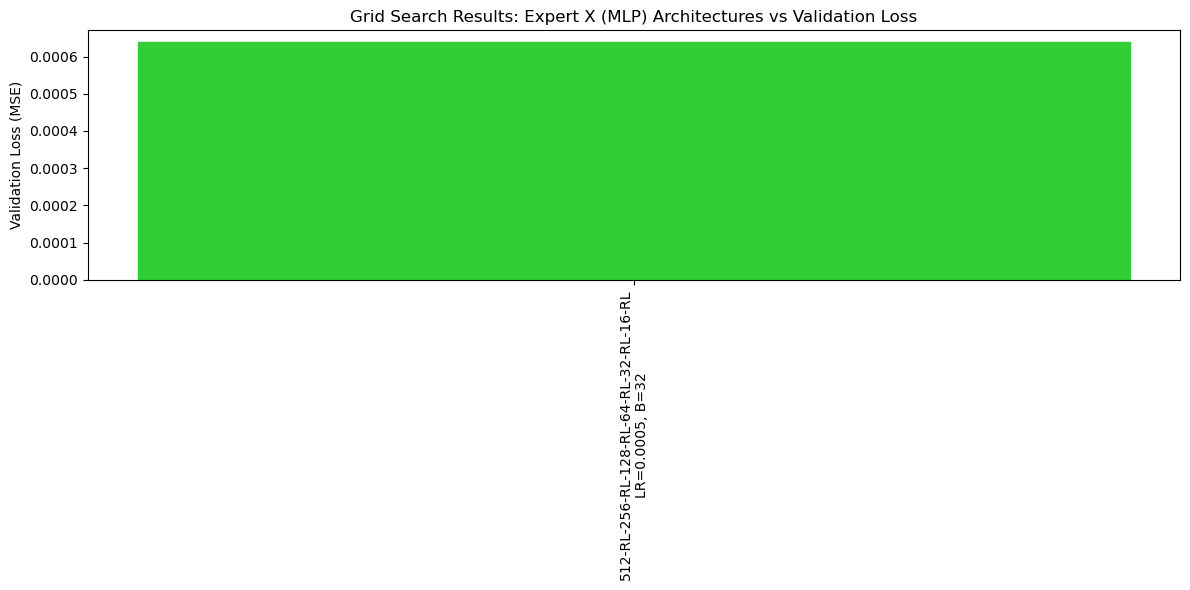

✅ Best model: 512-RL-256-RL-128-RL-64-RL-32-RL-16-RL
LR=0.0005, B=32 with val_loss = 0.000638


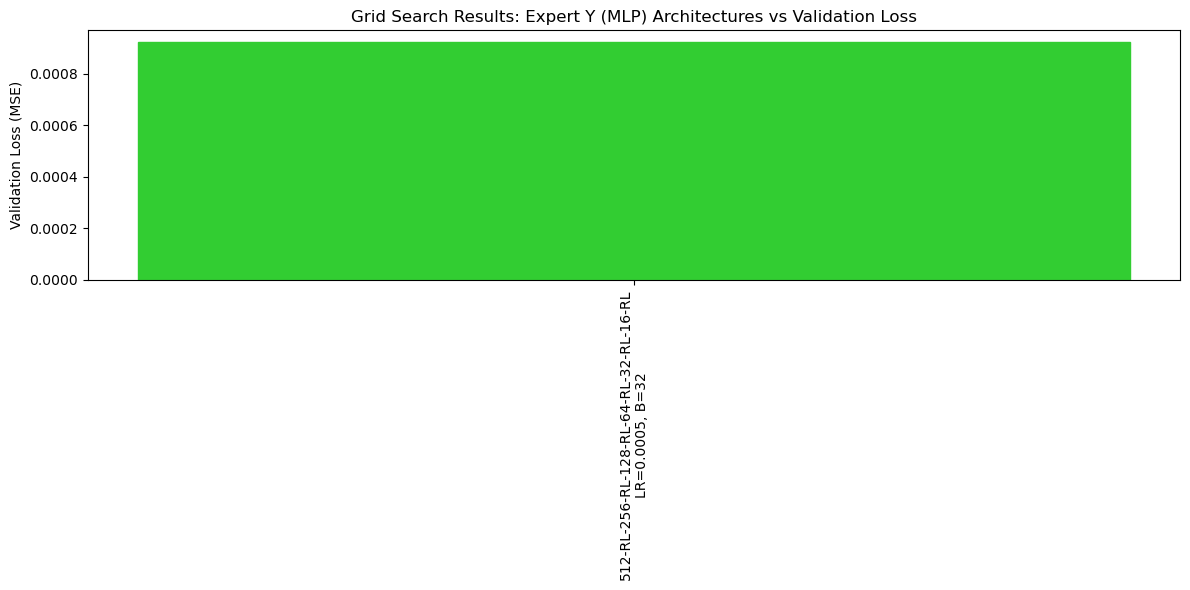

✅ Best model: 512-RL-256-RL-128-RL-64-RL-32-RL-16-RL
LR=0.0005, B=32 with val_loss = 0.000922


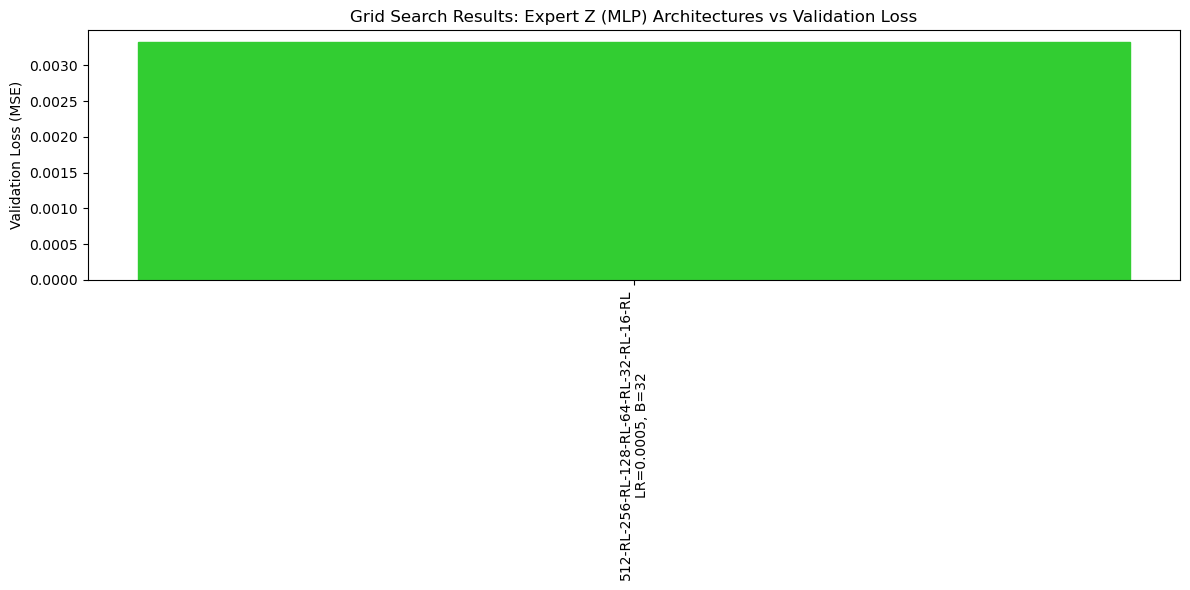

✅ Best model: 512-RL-256-RL-128-RL-64-RL-32-RL-16-RL
LR=0.0005, B=32 with val_loss = 0.003326


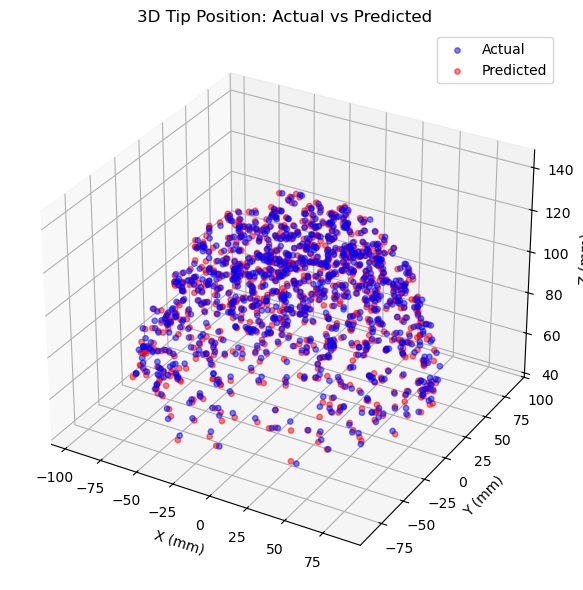

Mean residual distance: 1.787 mm
RMSE [x, y, z]: [1.12801945 1.30190324 1.09598152]
MAE  [x, y, z]: [0.88572194 0.98317694 0.80488456]
Mean 3D deviation: 1.7865 ± 0.9884


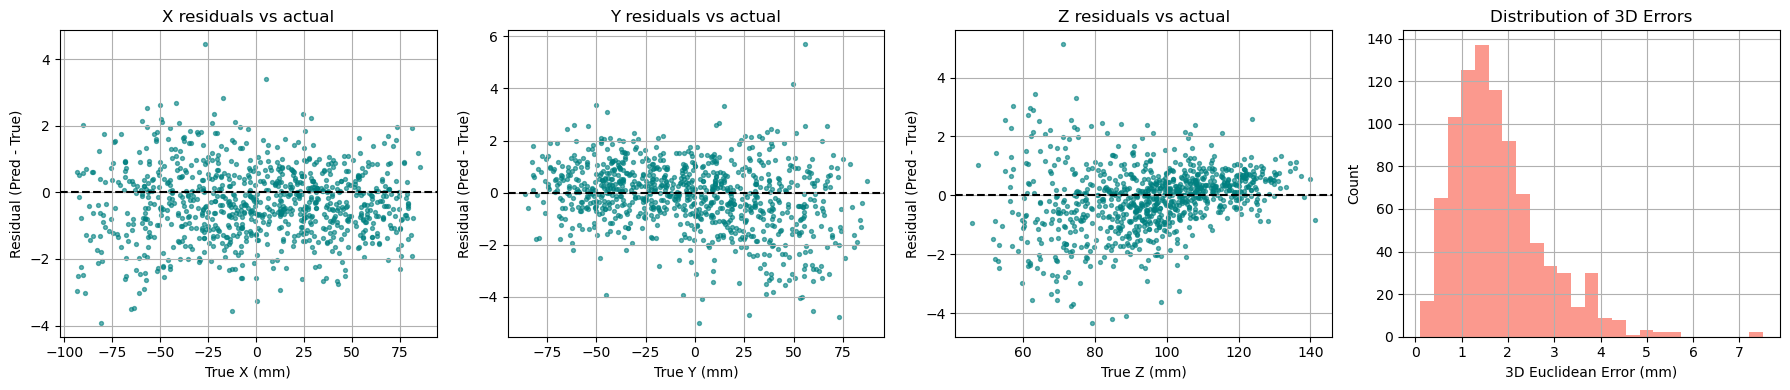

Mean 3D deviation: 1.7865 ± 0.9884


In [10]:
# --- Predict with all 3 experts (respecting dependency) ---
with torch.no_grad():
    preds = {}

    # --- Predict X ---
    model_x = experts['x']["best_model"]
    idx_x   = experts['x']["feature_idx"]
    model_x.eval()

    X_tensor_x = torch.tensor(X_test[:, idx_x], dtype=torch.float32)
    pred_x = model_x(X_tensor_x).cpu().numpy()
    preds['x'] = pred_x

    # --- Predict Y ---
    model_y = experts['y']["best_model"]
    idx_y   = experts['y']["feature_idx"]
    model_y.eval()

    X_tensor_y = torch.tensor(X_test[:, idx_y], dtype=torch.float32)
    pred_y = model_y(X_tensor_y).cpu().numpy()
    preds['y'] = pred_y

    # --- Predict Z (using X, Y predictions as extra inputs) ---
    model_z = experts['z']["best_model"]
    idx_z   = experts['z']["feature_idx"]
    model_z.eval()

    # build Z input: its features + predicted X, Y
    X_z_base = X_test[:, idx_z]
    X_z_full = np.hstack([X_z_base, preds['x'], preds['y']])

    X_tensor_z = torch.tensor(X_z_full, dtype=torch.float32)
    pred_z = model_z(X_tensor_z).cpu().numpy()
    preds['z'] = pred_z

    # combine all predictions
    y_pred = np.hstack([preds['x'], preds['y'], preds['z']])

# --- De-standardize ---
y_pred_real = y_scaler.inverse_transform(y_pred)
y_test_real = y_scaler.inverse_transform(y_test)

# --- Evaluation & Visualization ---
print("\n📈 Evaluating 3-Expert Model")

# visualize each coordinate’s grid search results
_ = plot_grid_search_results(experts['x']["results"], model_type="Expert X (MLP)")
_ = plot_grid_search_results(experts['y']["results"], model_type="Expert Y (MLP)")
_ = plot_grid_search_results(experts['z']["results"], model_type="Expert Z (MLP)")

# global 3D evaluation
_, _, _ = plot_3d_actual_vs_predicted(y_test_real, y_pred_real)
_ = compute_3d_metrics(y_pred_real, y_test_real)
_, _ = plot_residuals_and_errors(y_test_real, y_pred_real)
